# Week 07 Group 40

## Import necessary modules

In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import Model

## Load the dataset

In [166]:
(input_train, label_train), (input_test, label_test) = tf.keras.datasets.fashion_mnist.load_data()
print("min = {} max = {}".format(input_train.min(),input_train.max()))

min = 0 max = 255


## Print some images with their lables

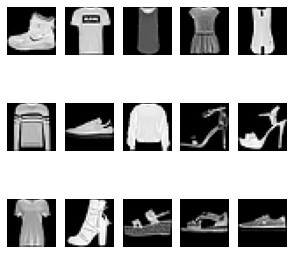

In [167]:
fig, ax = plt.subplots(3,5, figsize = (5,5))
ax = ax.flatten()
for i in range(15):
    img = input_train[i]

    ax[i].imshow(img, cmap='gray')
    ax[i].axis("off")

In [168]:
def preprocess(input, label):
    input = input/255
    input = tf.reshape(input,(28,28,1))
    print(input)
    label = tf.one_hot(label, 10)
    label = tf.reshape(label, (-1,))
    return (input, label)
input_train = tf.data.Dataset.from_tensor_slices(input_train)
label_train = tf.data.Dataset.from_tensor_slices(label_train)
input_test = tf.data.Dataset.from_tensor_slices(input_test)
label_test = tf.data.Dataset.from_tensor_slices(label_test)
train_ds = tf.data.Dataset.zip((input_train, label_train)) 
test_ds = tf.data.Dataset.zip((input_test, label_test))
train_ds = train_ds.map(preprocess)
test_ds = test_ds.map(preprocess)
train_ds =   (tf.data.Dataset.shuffle(train_ds,buffer_size = 100000, reshuffle_each_iteration=True).batch(64)).prefetch(3)
test_ds =   (tf.data.Dataset.shuffle(test_ds,buffer_size = 100000, reshuffle_each_iteration=True).batch(64)).prefetch(3)

Tensor("Reshape:0", shape=(28, 28, 1), dtype=float32)
Tensor("Reshape:0", shape=(28, 28, 1), dtype=float32)


## Convolutional autoencoder

### Encoder

In [138]:
class Encoder(Model):
    def __init__(self):
        super(Encoder, self).__init__()

        self.conv_layer1 = tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, padding = "same", activation = "relu", input_shape = (28,28,1))
        self.pool_layer1 = tf.keras.layers.MaxPool2D(pool_size = 2, padding = "same")

        self.conv_layer2 = tf.keras.layers.Conv2D(filters = 8, kernel_size = 3, padding = "same", activation = "relu")
        self.pool_layer2 = tf.keras.layers.MaxPool2D(pool_size = 2, padding = "same")

        self.conv_layer3 = tf.keras.layers.Conv2D(filters = 8, kernel_size = 3, padding = "same", activation = "relu")

        #self.flat_layer = tf.keras.layers.Flatten()
        
        self.dense_layer = tf.keras.layers.Dense(units = 10, activation = "sigmoid")

    def __call__(self, x):
        x = self.conv_layer1(x)
        x = self.pool_layer1(x)

        x = self.conv_layer2(x)
        x = self.pool_layer2(x)

        x = self.conv_layer3(x)

        #x = self.flat_layer(x)
        
        x = self.dense_layer(x)
        return x

### Decoder

In [147]:
class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder, self).__init__()

        self.dense_layer = tf.keras.layers.Dense(units = 64*49, activation = None)
        self.reshape_layer = tf.keras.layers.Reshape(target_shape=(7,7,64))

        self.conv_layer1 = tf.keras.layers.Conv2DTranspose(filters = 8 , kernel_size = 3, strides = 2, padding = "same", activation = None)
        self.conv_layer2 = tf.keras.layers.Conv2DTranspose(filters = 8, kernel_size = 3, strides = 2, padding = "same", activation = None)
        self.conv_layer3 = tf.keras.layers.Conv2DTranspose(filters = 16, kernel_size = 3, strides = 1, padding = "same", activation = None)

        #self.flat_layer2 = tf.keras.layers.Flatten()

        #self.dense_layer = tf.keras.layers.Dense(units = 784, activation = None)

        self.output_layer = tf.keras.layers.Conv2D(filters = 1, kernel_size= 3, padding = "same", activation = "sigmoid")

    def __call__(self, x):
        x = self.dense_layer(x)
        x = self.reshape_layer(x)

        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)

        x = self.output_layer(x)
        return x

### Autoencoder

In [139]:
class Autoencoder(tf.keras.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = Encoder()

        self.decoder = Decoder()

    def __call__(self, x):
        x = self.encoder(x)

        x = self.decoder(x)
        
        return x

## Define training and test step

In [140]:
def train_step(model, input, target, loss_function, optimizer):
    with tf.GradientTape() as tape:
        expectation = model(input)
        train_accuracy =  1
        loss = loss_function(input, expectation)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, train_accuracy

#test for loss and retrieve images for comparison later
def test(model, test_data, loss_function):
    imgs = []
    #test_org_img_total = []
    test_losses_total = []
    # Compute and return loss and accuracy of Test-data
    for (input, target) in test_data:
        expectation = model( input)
        test_loss = loss_function(input, expectation)
        imgs.append((input, expectation))
        test_losses_total.append(test_loss)
    
    # take the mean of all losses
    test_losses_total = np.mean(test_losses_total)
    return test_losses_total, imgs

## Train the Model for 20 epochs

In [141]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [160]:
# initialize the model
model = Autoencoder()
# use MeanSquaredError as loss function
loss_function = tf.keras.losses.MeanSquaredError()
# use adam as optimizer
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)
# lists for plotting later
test_loss_list = []
test_accuracy_list = []

train_loss_list = []
train_accuracy_list = []

In [161]:
num_epochs = 10

test_loss_list = []
test_accuracy_list = []

train_loss_list = []
train_accuracy_list = []

# we train for the predefined number of epochs
for step in range(num_epochs):
    # reset average for each step
    changing_average = []
    train_accuracy_agg = []
    # train the model with the training data
    for (input, target) in train_ds:
        # perform training step and store the loss and accuracy of step
        with tf.device('/device:GPU:0'):
          train_loss, train_accuracy = train_step(model, input, target, loss_function, optimizer)
          changing_average.append(train_loss)
          train_accuracy_agg.append(np.mean(train_accuracy))

    # compute mean loss and accuracy of trainingcycle
    train_loss_list.append(np.mean(changing_average))
    train_accuracy_list.append(np.mean(train_accuracy_agg))
    
    # test on the test data
    with tf.device('/device:GPU:0'):
      test_loss, test_accuracy = test(model, test_ds, loss_function)
      test_loss_list.append(test_loss)
      test_accuracy_list.append(test_accuracy)
      model.save_weights('saved_model_weights_autoencoder')
      model.save_weights('saved_model_weights_autoencoder.h5')
    print("Epoch: " + str(step + 1))
    #print("Training Accuracy: " + str(train_accuracy_list[step]))# + 1
    #print("Test Accuracy: " + str(test_accuracy_list[step]))# + 1
   
model.save_weights('saved_model_weights_autoencoder')
model.save_weights('saved_model_weights_autoencoder.h5')

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10


## Take a look at the accuracy and loss during training and on the test data

In [162]:
print(train_loss_list)
print(test_loss_list)

[0.033691954, 0.021685252, 0.020847417, 0.0204279, 0.020123415, 0.019904729, 0.019769078, 0.01962039, 0.019511098, 0.019425841]
[0.022504909, 0.021394337, 0.020928966, 0.020231303, 0.020354638, 0.019919518, 0.019596707, 0.019761492, 0.019341437, 0.019516334]


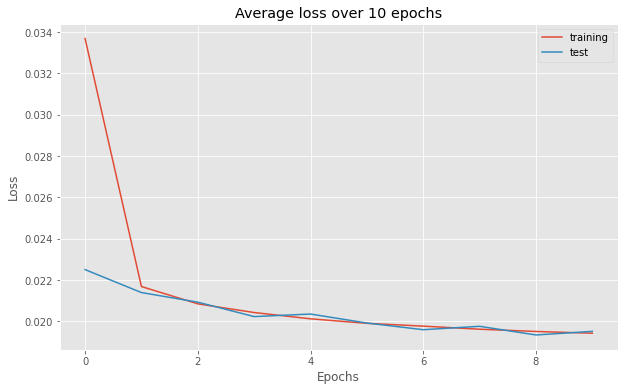

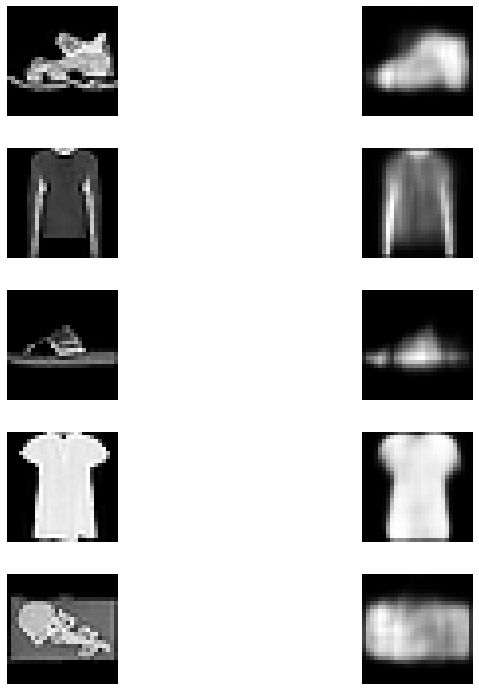

In [163]:
# plot the loss
plt.style.use('ggplot')
fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize = (10, 6))

ax1.plot(train_loss_list, label='training')
ax1.plot(test_loss_list, label='test')
ax1.set(ylabel='Loss', xlabel='Epochs', title=f'Average loss over {num_epochs} epochs')

ax1.legend()


# compare the images
for (input, expectation) in test_accuracy:
  input = tf.squeeze(input)
  expectation = tf.squeeze(expectation)
    
  fig, ax = plt.subplots(5,2, figsize = (10,10))
  fig.tight_layout()
  for i in range(5):
    ax[i][0].imshow(input[i], cmap = "gray")
    ax[i][0].axis('off')
    ax[i][1].imshow(expectation[i], cmap = "gray")
    ax[i][1].axis('off')

  plt.show()
         
  break

## Latent space analysis

In [169]:
from sklearn.manifold import TSNE 
tsne = TSNE(n_components=2, random_state=0)
embeddings = []
with tf.device('/device:GPU:0'):
  for img in input_test.take(2):
    #embeddings = tf.reshape(model.encoder(img), -1)
    embeddings.append(tf.reshape(model.encoder((tf.expand_dims(tf.expand_dims(tf.cast(img/255, tf.float32),2),3))),(-1)))#
    print(model.encoder((tf.expand_dims(tf.expand_dims(tf.cast(img/255, tf.float32),2),3))).shape)
  #embeddings = tf.reshape(embeddings, (-1,1))
  #embeddings = [tf.reshape(model.Encoder(img), (-1,)) for img in latent_space_images]
  tsne_embeddings = tsne.fit_transform(embeddings)

InvalidArgumentError: ignored

In [171]:
print(len(embeddings))
print(embeddings[1])

0


IndexError: ignored

In [174]:
(input_train, label_train), (input_test, label_test) = tf.keras.datasets.fashion_mnist.load_data()
from bokeh.models import ColumnDataSource
from bokeh.palettes import Spectral10
from bokeh.io import output_notebook
from bokeh.plotting import figure, show, output_file
from bokeh.transform import factor_cmap

output_notebook()

label_names = ["t-shirt/top", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot"]
latent_space_labels = [label_names[int(entry)] for entry in label_test[:1000]]

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="2D Encoder Embeddings of first 1000 Test Images")

source = ColumnDataSource(data=dict(x1=tsne_embeddings[:,0],
                                    x2=tsne_embeddings[:,1],
                                    names=latent_space_labels))

p.scatter(x="x1", y="x2", size=6, source=source, fill_color=factor_cmap('names', palette=Spectral10, factors=label_names), fill_alpha=0.4, line_color=factor_cmap('names', palette=Spectral10, factors=label_names), legend_field='names') 

show(p)

In [156]:
def interpolate(embedding1, embedding2, n_steps=15):
  ratios = np.linspace(0, 1, num=n_steps)
  interpolation_list = [(1.0 - ratio) * embedding1 + ratio * embedding2 for ratio in ratios]
  return interpolation_list

interpolations = interpolate(embeddings[0], embeddings[1])
#print(interpolations[1].shape)
# plot the interpolated images
fig, ax = plt.subplots(1, 10, figsize = (30,30))
fig.tight_layout()
for i in range(10):
  img = model.decoder(tf.reshape(interpolations[i],(1,10)))
  ax[i].imshow(tf.squeeze(img), cmap = "gray")
  ax[i].axis('off')
    

IndexError: ignored